In [1]:
import numpy as np
import scipy

from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import lightning as L

# Load Dataset

In [2]:
import os
os.path.abspath('.')

'/home/reinhardt/ml-pws/notebooks'

In [3]:
data = scipy.io.loadmat('../data/barmovie0113extended.data', squeeze_me=True)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'rep_begin_time', 'rep_end_time', 'PickedCells', 'SpikeTimes', 'peak_times', 'stim'])

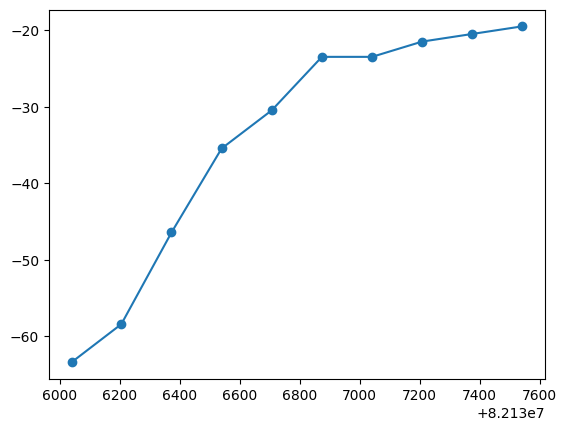

In [4]:
plt.plot(data['peak_times'][-10:], data['stim'][-10:], 'o-')

In [5]:
data['stim'].shape, data['peak_times'].shape

((487889,), (487891,))

In [6]:
dt = 1e-4

(66.0316, 71.0316)

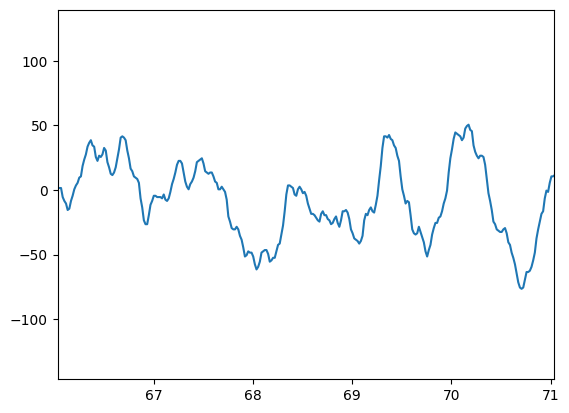

In [7]:
plt.plot(data['peak_times'][1:-1] * dt, data['stim'])
plt.xlim(data['peak_times'][0] * dt, data['peak_times'][0]*dt+5)

In [8]:
len(data['SpikeTimes'])

230

(180.0, 300.0)

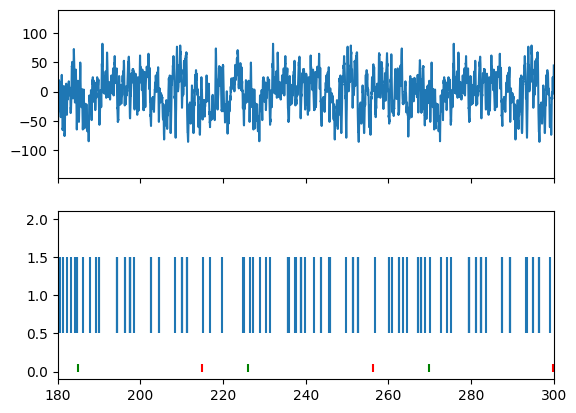

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(data['peak_times'][1:-1] * dt, data['stim'])
ax2.eventplot(data['SpikeTimes'][3] * dt)
ax2.vlines(data['rep_begin_time'] * dt, 0, 0.1, color='green')
ax2.vlines(data['rep_end_time'] * dt, 0, 0.1, color='red')
ax2.set_xlim(180, 300)

In [10]:
peak_times = data['peak_times'][:-2]
rep_mask = (peak_times[:, np.newaxis] >= data['rep_begin_time']) * (peak_times[:, np.newaxis] < data['rep_end_time'])
spike_times = data['SpikeTimes'][1]
spike_mask = (spike_times[:, np.newaxis] >= data['rep_begin_time']) * (spike_times[:, np.newaxis] < data['rep_end_time'])
rep_mask.shape, spike_mask.shape

((487889, 136), (4127, 136))

In [11]:
spike_times[spike_mask[:, 0]] * dt

array([188.4099, 188.4688, 188.4906, 191.0803, 194.2761, 194.2815,
       198.2389, 200.4405, 203.1024, 203.5345, 203.6239, 203.777 ,
       206.957 , 206.9615, 207.017 , 209.3561, 213.7506])

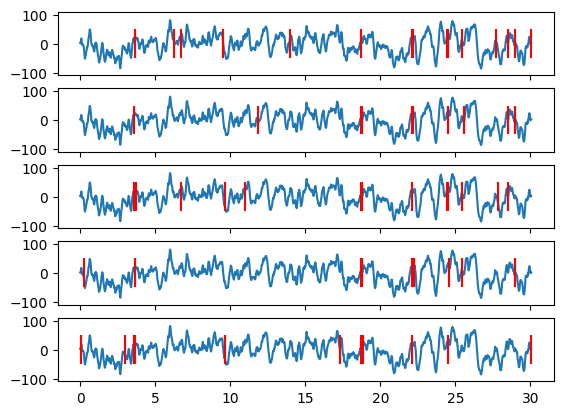

In [12]:
fig, axs = plt.subplots(5, sharex=True)

for i, ax in zip([10,20,30,45,120], axs):
    t0 = data['rep_begin_time'][i] * dt
    mask = rep_mask[:, i]
    t = peak_times[mask] * dt
    ax.plot(t - t0, data['stim'][mask])
    ax.eventplot(spike_times[spike_mask[:, i]] * dt - t0, linelengths=100.0, color='red')

In [13]:
t_start = data['rep_begin_time'][0]
t_end = data['rep_end_time'][10]
grid = np.arange(t_start, t_end, 50)
grid.shape

(100547,)

<StemContainer object of 3 artists>

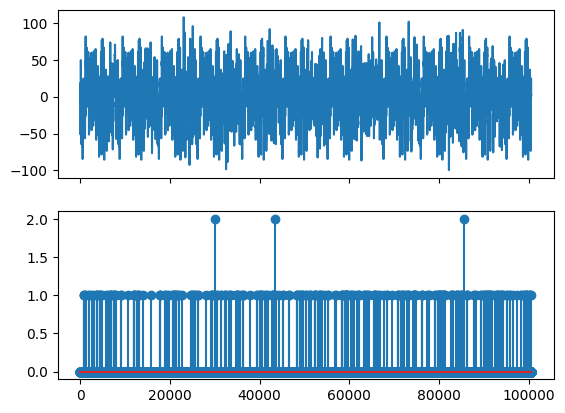

In [14]:
idx = np.searchsorted(peak_times, grid)
stimulus = data['stim'][idx]
hist, _ = np.histogram(spike_times, bins=np.concat([grid, [t_end]]))
f, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(stimulus)
ax2.stem(hist)

In [15]:
def bin_neurons(data, neurons, t_start, t_end):
    grid = np.arange(t_start, t_end, 50)

    peak_times = data['peak_times'][:-2]
    idx = np.searchsorted(peak_times, grid)
    stimulus = data['stim'][idx]

    spikes_binned = []
    for n in neurons:
        spike_times = data['SpikeTimes'][n]
        hist, _ = np.histogram(spike_times, bins=np.concat([grid, [t_end]]))
        spikes_binned.append(hist)

    return stimulus, np.stack(spikes_binned, axis=-1)

def make_dataset(data, neurons):
    s = []
    x = []
    for t_start, t_end in zip(data['rep_begin_time'], data['rep_end_time']):
        stim, spikes = bin_neurons(data, neurons, t_start, t_end)
        s.append(torch.tensor(stim, dtype=torch.float32))
        x.append(torch.tensor(spikes, dtype=torch.float32))
    return nn.utils.rnn.pad_sequence(s), nn.utils.rnn.pad_sequence(x)

In [16]:
s, x = make_dataset(data, [1, 2, 3])
s.shape, x.shape

(torch.Size([6019, 136]), torch.Size([6019, 136, 3]))

In [21]:
class ConditionalSpikeModel(nn.Module):
    def __init__(self, n_neurons: int, hidden_size: int, num_layers: int = 1):
        super().__init__()
        self.hidden_dim = hidden_size
        self.num_layers = num_layers
        self.n_neurons = n_neurons

        # RNN layer (stimulus dimension is 1)
        self.rnn = nn.GRU(1 + n_neurons, hidden_size, num_layers, batch_first=False, dropout=0.3)

        # Linear layer to output spike prob for each neuron
        self.output_layer = nn.Linear(hidden_size, n_neurons)

    def forward(self, s: torch.Tensor, x: torch.Tensor):
        seq_len, batch_size, n_neurons = x.size()

        if seq_len != s.size(0):
            raise ValueError(f"Sequence lengths do not match.")

        if n_neurons != self.n_neurons:
            raise ValueError(f"Wrong shape of x: {x.size()}. Expected last dimension {self.n_neurons}.")

        if s.ndim == 2:
            s = s.unsqueeze(-1)

        # shift right
        x = x.roll(1, 0)  # (batch_size, seq_len, 1)
        x[0, :, :] = 0.0

        # Forward through RNN
        rnn_out, _ = self.rnn(torch.cat([s, x], dim=2))

        output = self.output_layer(rnn_out)  # (seq_len, batch_size, n_neurons)

        # returns the logits
        return output

In [22]:
model = ConditionalSpikeModel(3, 64, 4)
model

ConditionalSpikeModel(
  (rnn): GRU(4, 64, num_layers=4, dropout=0.3)
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)

In [23]:
class SpikeRnn(L.LightningModule):
    def __init__(self, n_neurons: int, hidden_size: int, num_layers: int = 1):
        super().__init__()
        self.net = ConditionalSpikeModel(n_neurons, hidden_size, num_layers)

    def training_step(self, batch, batch_idx):
        s, x = batch
        x = torch.clamp(x, 0, 1)
        loss = nn.BCEWithLogitsLoss()
        logits = self.net(s, x)
        train_loss = loss(logits, x)
        self.log("train_loss", train_loss)
        return train_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [24]:
train_dataset = TensorDataset(s, x)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=False)
spike_rnn = SpikeRnn(3, 64, 2)
trainer = L.Trainer(max_epochs=50)
trainer.fit(model=spike_rnn, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type                  | Params | Mode 
-------------------------------------------------------
0 | net  | ConditionalSpikeModel | 38.6 K | train
-------------------------------------------------------
38.6 K    Trainable params
0         Non-trainable params
38.6 K    Total params
0.154     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/reinhardt/.local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/61 [00:00<?, ?it/s] 

Epoch 49: 100%|██████████| 61/61 [00:06<00:00,  9.84it/s, v_num=43]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 61/61 [00:06<00:00,  9.82it/s, v_num=43]


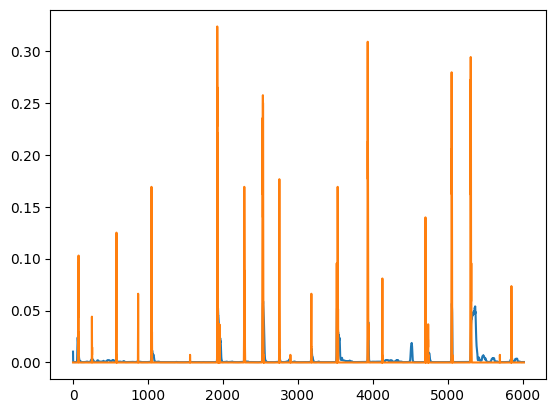

In [35]:
plt.plot(nn.functional.sigmoid(spike_rnn.net(s, x).detach()).mean(1)[:, 2])
plt.plot(x.mean(1)[:, 2])